In [1]:
!pip install kagglehub
!pip freeze > requirements.txt

##  Dataset Download and Setup

In [4]:
import os
import kagglehub

# Step 1: Download
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

# Step 2: Define the real dataset folder for ImageFolder
img_dir = os.path.join(path, "cell_images", "cell_images")  # ✅ <- inner one



## Transform and Dataset Creation

In [5]:
# Step 3: Use in ImageFolder
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(img_dir, transform=transform)

print(dataset.class_to_idx)  # {'Parasitized': 0, 'Uninfected': 1}


{'Parasitized': 0, 'Uninfected': 1}


## Data Splitting and Loading

In [6]:

from torch.utils.data import DataLoader, random_split


# Split: 60/20/20
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
print(dataset.class_to_idx)
# {'Parasitized': 0, 'Uninfected': 1}


{'Parasitized': 0, 'Uninfected': 1}


## Model Loading and Modification

In [6]:
!pip install torch torchvision transformers matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn
import torch

# Load the pre-trained ViT model and feature extractor
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")



# Replace the final layer to match the number of classes (2 for "malaria" vs "non-malaria")
model.classifier = nn.Linear(model.config.hidden_size, 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set training to CUDA

In [9]:
# Set the device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


## Validating the function

In [10]:
# Function to evaluate the model on the validation set
def evaluate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate validation accuracy and loss
    accuracy = correct_predictions / total_predictions
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss, accuracy

## Early stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [12]:
early_stopping = EarlyStopping(patience=2, min_delta=0.001)


## Training

In [13]:
from tqdm import tqdm
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
# Training loop
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# Set up the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()


for epoch in range(5):
    running_loss = 0.0
    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}', unit='batch') as pbar:
        for images, labels in train_loader:
            optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)

            # Forward pass with autocast for mixed precision
            with autocast():
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

            # Scaler step
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / len(train_loader))
            pbar.update(1)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Validation step
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


<ipython-input-13-64f56bc9da02>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/517 [00:00<?, ?batch/s]<ipython-input-13-64f56bc9da02>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 517/517 [02:33<00:00,  3.37batch/s, loss=0.126]

Epoch 1, Loss: 0.12628747756292097


Validation Loss: 0.12263148701399823, Validation Accuracy: 95.86%


Epoch 2: 100%|██████████| 517/517 [02:30<00:00,  3.44batch/s, loss=0.0826]

Epoch 2, Loss: 0.08260335260191554


Validation Loss: 0.08640445412454233, Validation Accuracy: 96.90%


Epoch 3: 100%|██████████| 517/517 [02:30<00:00,  3.44batch/s, loss=0.0573]

Epoch 3, Loss: 0.0572572568723323


Validation Loss: 0.10217966947629187, Validation Accuracy: 96.55%


Epoch 4: 100%|██████████| 517/517 [02:28<00:00,  3.47batch/s, loss=0.0455]

Epoch 4, Loss: 0.04545240662001232


Validation Loss: 0.09247487831343977, Validation Accuracy: 97.01%
Early stopping triggered.


## Saving the fine-tuned model

In [14]:
torch.save(model.state_dict(), "vit-malaria.pt")

## Testing

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 97.01%


## Vizualising

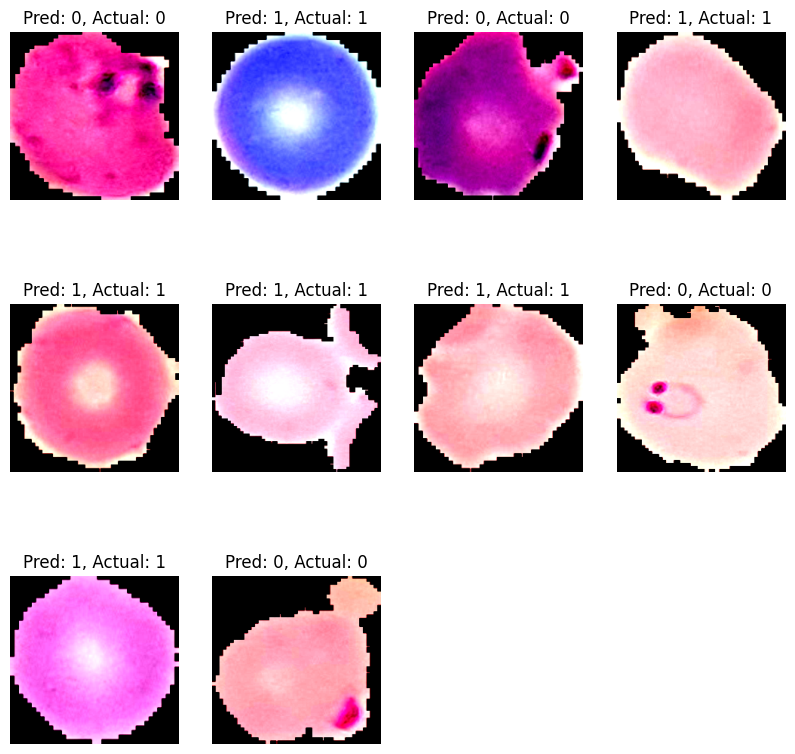

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a data iterator for the test dataset
data_iter = iter(test_loader)

# Get the first batch (this will be 32 images if batch_size=32)
images, labels = next(data_iter)

# Pick the first 10 images for visualization
images = images[:10]
labels = labels[:10]

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs.logits, 1)

# Plot the images and predictions
fig = plt.figure(figsize=(10, 10))
for idx in range(10):
    ax = fig.add_subplot(3, 4, idx + 1)  # Adjust the grid for 10 images
    ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Pred: {preds[idx].item()}, Actual: {labels[idx].item()}")
    ax.axis('off')
plt.show()
